In [1]:


import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display, HTML
import plotly.express as px
import dataframe_image as dfi
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
pd.options.mode.chained_assignment = 'warn'  # default=
pd.options.plotting.backend = "plotly"
pd.options.display.float_format = '{:,.2f}'.format
PATH_CACHE = Path("../../data/algos_results.csv").resolve()
print(PATH_CACHE)
pd.set_option('display.max_columns', None)  

C:\Users\robin\Documents\Cours\Poly\Recherche\MaitriseClustering\data\algos_results.csv


In [188]:
orig_df = pd.read_csv(PATH_CACHE, sep=",",header=0,index_col=False)
for orig_name,new_name in [("CallbackBestImprovement","BI"),("CallbackFirstImprovement","FI")]:
    orig_df.loc[orig_df.ImprClass == orig_name,"ImprClass"] = new_name
orig_df.loc[:,"algorithm"] = orig_df["ImprClass"]+"_" + orig_df["iteration_order"]
orig_df.loc[:,"Nb. points"] = orig_df["num_points"]
orig_df.drop(["ImprClass","iteration_order","num_iter","global_index"],axis=1,inplace=True)
df = orig_df.copy()
dico_comp = {}
Ldf_clusters = []
for num_clusters in [2**i for i in range(1,8)]:
    df_clust = df[df["num_clusters"] == num_clusters].copy()
    dico_df_init = {}
    for init_type in pd.unique(df["init_type"]):
        df_init = df_clust[df_clust["init_type"] == init_type].copy()
        dico_df_costs = {}
        dico_df_time = {}
        dico_df_num_iter_tot = {}
        # Average cost computation
        for algorithm in pd.unique(df_init["algorithm"]):
            df_algo = df_init[df_init["algorithm"] == algorithm].copy()
            df_algo = df_algo.groupby("num_points",as_index=False).mean()
            df_algo.set_index(["Nb. points"],inplace=True)
            
            if algorithm == "BI_BACK":
                columns = ["num_points","init_cost","end_cost"]
            else:
                columns = ["num_points","end_cost"]
            dico_df_costs[algorithm] = df_algo[columns].copy()
                
            dico_df_time[algorithm] = df_algo[["num_points","time"]].copy().drop(["num_points"],axis=1)
            dico_df_num_iter_tot[algorithm] = df_algo[["num_points","num_iter_tot"]].copy().drop(["num_points"],axis=1)
        dico_impr_algos = {}
        # Average improvement computation
        for algorithm_name,df_algo in dico_df_costs.items():
            if algorithm_name == "BI_BACK":
                continue
            BI_BACK = dico_df_costs["BI_BACK"][["num_points","end_cost"]].copy()
            FI = df_algo[["num_points","end_cost"]].copy()
            dico_impr_algos[algorithm_name] = ((BI_BACK - FI)/BI_BACK*100).drop(["num_points"],axis=1)
        for algorithm_name,df_algo in dico_df_costs.items():
            df_algo.drop(["num_points"],axis=1,inplace=True)
        if len(dico_impr_algos) > 1:
            cost_df_comp = pd.concat(dico_df_costs.values(),axis=1,keys=dico_df_costs.keys())
            impr_df_comp = pd.concat(dico_impr_algos.values(),axis=1,keys=dico_impr_algos.keys())
            num_points = [int(i) for i in impr_df_comp.index]
            impr_df_comp.insert(loc=0,column="points/centroid",value=np.array(num_points)/num_clusters)
            time_df_comp = pd.concat(dico_df_time.values(),axis=1,keys=dico_df_time.keys())
            num_iter_comp = pd.concat(dico_df_num_iter_tot.values(),axis=1,keys=dico_df_num_iter_tot.keys())
            clust_comp_df = pd.concat([cost_df_comp,impr_df_comp,time_df_comp,num_iter_comp],axis=1,keys=["Coût final","% amélioration","Temps d'exécution (s)","Nombre d'itérations"])
            dico_df_init[init_type] = clust_comp_df
    if len(dico_df_init) == 0:
        pass
    elif len(dico_df_init) == 1:
        print("Pour le nombre de clusters : ",num_clusters)
        print(display(dico_df_init[list(dico_df_init.keys())[0]]))
    else:
        comp_init = pd.concat(dico_df_init.values(),axis=1,keys=dico_df_init.keys())
        # print("Pour le nombre de clusters : ",num_clusters)
        # print(display(comp_init))
        # dfi.export(comp_init,f"comp_{num_clusters}_clusters.png",max_cols=-1)
        dico_comp[num_clusters] = comp_init


In [189]:
# sample the colormaps that you want to use. Use 128 from each so we get 256
def generate_cmap(negative_good=True):
    # thanks to https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps
    # colors in total
    Lintervals = [
        (1,0),
        (0.,1.)
    ]
    Lcmap_names = ["Reds","Greens"]
    if negative_good:
        Lcmap_names = Lcmap_names[::-1]
    Lcmaps = [
        plt.get_cmap(name)(np.linspace(*interval,128)) for name,interval in zip(Lcmap_names,Lintervals)
    ]
    

    # combine them and build a new colormap
    colors = np.vstack(Lcmaps)
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    return mymap
def select_col(x):
    c1 = 'background-color: red'
    c2 = '' 
    #compare columns
    mask = x['Diff'] > x['HistoricStandardDev']
    #DataFrame with same index and columns names as original filled empty strings
    df1 =  pd.DataFrame(c2, index=x.index, columns=x.columns)
    #modify values of df1 column by boolean mask
    df1.loc[mask, 'Current'] = c1
    return df1

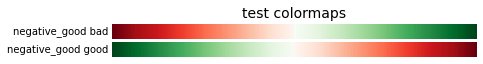

In [190]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
def plot_color_gradients(cmap_category, cmap_list,titles):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)

    axs[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, cmap_name,name in zip(axs, cmap_list,titles):
        ax.imshow(gradient, aspect='auto', cmap=cmap_name)
        ax.text(-.01, .5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()
plot_color_gradients("test",[generate_cmap(negative_good=False),generate_cmap(negative_good=True)],["negative_good bad","negative_good good"])

In [191]:
for num_clusters,df_comp in dico_comp.items():
    Lindexes = [
        [(init,'% amélioration',algo,"end_cost") for algo in ["FI_CURR","FI_BACK","FI_RANDOM"]]
        for init in ['random','kmean+']
    ]
    styler = df_comp.copy().style
    i = 0
    for indexes,negative_good in zip(Lindexes,[False,False]):
        subset_list = [df_comp[index] for index in indexes]
        maxi = max(s.abs().max() for s in subset_list)
        if maxi == 0:
            continue
        styler.background_gradient(cmap=generate_cmap(negative_good=negative_good), axis=1,subset=indexes,vmin=-maxi,vmax=maxi)
    print("Pour le nombre de clusters : ",num_clusters)
    print(display(styler))
    # raise Exception("")

Pour le nombre de clusters :  2


None
Pour le nombre de clusters :  4


None
Pour le nombre de clusters :  8


None
Pour le nombre de clusters :  16


None
Pour le nombre de clusters :  32


None
Pour le nombre de clusters :  64


None


In [192]:
COLUMN = "% amélioration end_cost"
df = orig_df.copy().drop(columns=["num_points"])
grouped_cols = ["num_clusters","Nb. points","init_type","algorithm"]
df = df.groupby(grouped_cols).mean().reset_index()
df_BI = df[df["algorithm"] == "BI_BACK"].copy().set_index(grouped_cols)
Ldf = []
for algo in pd.unique(df["algorithm"]):
    df_algo = df[df["algorithm"] == algo].copy()
    df_algo["algorithm"] = "BI_BACK"
    df_algo = df_algo.set_index(grouped_cols)
    df_algo_orig = df_algo.copy()
    df_algo = (df_algo - df_BI)/df_BI*100
    df_algo.columns = ["% amélioration "+c for c in df_algo.columns]
    df_algo = pd.concat([df_algo_orig,df_algo],axis=1)
    df_algo = df_algo.reset_index()
    df_algo["algorithm"] = algo
    Ldf.append(df_algo)
df = pd.concat(Ldf,axis=0)
df["Nb. pts par clusters"] = df["Nb. points"]/df["num_clusters"]
ticks_pow = [-2,-1,0]
max_val = abs(min(ticks_pow))
delta_zero = 0.001+1
print(min(ticks_pow)-1,np.inf)
logscale = lambda x:  np.sign(x) * (1-min(ticks_pow)+np.clip(np.log10(np.abs(x+1e-16)),min(ticks_pow)-delta_zero,np.inf))
fig = px.scatter_3d(df,x="Nb. pts par clusters",y="init_type",z="algorithm",color=logscale(df[COLUMN]),
                    hover_data=["Nb. pts par clusters","init_type","algorithm",COLUMN],
                    color_continuous_scale=["red","yellow","green","cyan","blue"][::-1],
                    range_color=[-max_val-delta_zero,max_val+delta_zero],
                    template="plotly_dark",width=1000,height=900)
def build(f):
    ticks_pos = [f(1,p) for p in ticks_pow]
    ticks_neg = [f(-1,p) for p in ticks_pow[::-1]]
    return [*ticks_neg,logscale(0),*ticks_pos]
def func(sign,p):
    real_value = sign*10**p
    return logscale(real_value)
Lp = build(func)
print(Lp)
Lannot = build(lambda sign,p: "1E"+str(p) if sign > 0 else "-1E"+str(p))
print(Lp)
print(Lannot)
fig.update_layout(coloraxis_colorbar=dict(
    title=COLUMN,
    tickvals=np.round(Lp,decimals=2),
    ticktext=Lannot,
))
fig.show()

-3 inf
[-3.0, -1.9999999999999996, -0.9999999999999956, -0.0, 1.0000000000000044, 2.0000000000000004, 3.0]
[-3.0, -1.9999999999999996, -0.9999999999999956, -0.0, 1.0000000000000044, 2.0000000000000004, 3.0]
['-1E0', '-1E-1', '-1E-2', -0.0, '1E-2', '1E-1', '1E0']


In [66]:
class SignColorFormatter:
    def format(self,df):
        original_df = df.copy()
        df.loc[
            original_df["cost_augm_BI_ref"] < 0, "cost_augm_BI_ref"
        ] = "decrease"
        df.loc[
            original_df["cost_augm_BI_ref"] > 0, "cost_augm_BI_ref"
        ] = "increase"
        df.loc[
            original_df["cost_augm_BI_ref"] == 0, "cost_augm_BI_ref"
        ] = "no_change"
        return df
    def get_colors(self):
        return {"decrease":"red","increase":"green","no_change":"blue"}
class MultipleRanges:
    def __init__(self):
        self.dico = {"#9E2A2B":[100,99999],
                     "#F3722C":[10,100],
                     "#F8961E":[1,10],
                     "#F9844A":[0,1],
                     "white": 0,
                     "#C6FF94":[-1,0],
                     "#00BC78":[-10,-1],
                     "#4D908E":[-100,-10],
                     "#245F84":[-99999,-100],
                     }
    def format(self,df):
        original_df = df.copy()
        for ranges in self.dico.values():
            if isinstance(ranges,list):
                if  ranges[1] in self.dico.values():
                    localization = (original_df["cost_augm_BI_ref"] > ranges[0]) & (original_df["cost_augm_BI_ref"] < ranges[1])
                else:
                    localization = (original_df["cost_augm_BI_ref"] > ranges[0]) & (original_df["cost_augm_BI_ref"] <= ranges[1])
                    
                df.loc[
                    localization, "cost_augm_BI_ref"
                ] = str(ranges)
            elif isinstance(ranges,int):
                df.loc[
                    original_df["cost_augm_BI_ref"] == ranges, "cost_augm_BI_ref"
                ] = str(ranges)
            else:
                print(f"WARNING: ranges {ranges} is not a list or int")
        return df
    def get_colors(self):
        return {str(ranges):color for color,ranges in self.dico.items()}
    
def reformat(df, init="random", average=True, color_formatter=None):
    tmp_df = df[df["init_type"] == init].copy()
    tmp_df.loc[:, "algorithm"] = tmp_df["ImprClass"] + "_" + tmp_df["iteration_order"]
    tmp_df.loc[:, "index"] = (
        tmp_df["uuid_points_coords"]
        + "_"
        + tmp_df["uuid_points_assign"]
        + "_"
        + tmp_df["num_points"].astype(str)
    )
    tmp_df = tmp_df.drop(
        [
            "init_cost",
            "ImprClass",
            "init_type",
            "iteration_order",
            "uuid_points_coords",
            "uuid_points_assign",
        ],
        axis=1,
    )
    Lnew = []
    for num_clust in [2, 4, 8, 16, 32, 64, 128]:
        df_tmp = tmp_df[tmp_df["num_clusters"] == num_clust].copy()
        Ldf = []
        for algorithm in pd.unique(df_tmp["algorithm"]):
            df_tmp1 = df_tmp[df_tmp["algorithm"] == algorithm].copy()
            df_tmp1.set_index(["index"], inplace=True)
            if "Best" in algorithm:
                backup_tmp_df = df_tmp1.copy()
                backup_tmp_df.loc[:, "algorithm"] = algorithm
                backup_tmp_df.loc[:, "num_clusters"] = num_clust
                continue
            else:
                current = df_tmp1
                df_tmp1 = df_tmp1.assign(
                    cost_augm_BI_ref=current["end_cost"].copy()
                    - backup_tmp_df["end_cost"].copy()
                )
            if average:
                df_tmp1 = df_tmp1.groupby("num_points", as_index=False).mean()
            df_tmp1.loc[:, "algorithm"] = algorithm
            df_tmp1.loc[:, "num_clusters"] = num_clust
            new_df_tmp1 = df_tmp1.copy()
            if color_formatter is not None:
                new_df_tmp1 = color_formatter.format(new_df_tmp1)
            Ldf.append(new_df_tmp1)
        if len(Ldf) > 0:
            Lnew.append(pd.concat(Ldf, axis=0))
    new_df = pd.concat(Lnew, axis=0)
    return new_df


def table(init_df, init="random"):
    df = reformat(init_df.copy(), init, average=False)
    return display(df)


def plot(init_df, init="random", color_formatter=None):
    df = reformat(init_df.copy(), init, color_formatter=color_formatter)
    # fig = px.scatter_3d(
    #     df,
    #     x="num_points",
    #     y="algorithm",
    #     z="num_clusters",
    #     log_z=True,
    #     color="cost_augm_BI_ref",
    #     color_discrete_map=color_formatter.get_colors() if color_formatter is not None else None,
    #     template="plotly_dark",
    #     width=1000,
    #     height=800,
    #     labels={
    #                  "num_points": "Nombre de points",
    #                  "algorithm": "Algorithme",
    #                  "num_clusters": "Nombre de clusters",
    #                  "cost_augm_BI_ref": "Augmentation du coût<br> par rapport à<br> Best Improvement"
    #              },
    #     category_orders={"cost_augm_BI_ref": (color_formatter.get_colors().keys()) } if color_formatter is not None else None ,
    #     title=f"Augmentation du coûtpar rapport à Best Improvement (CURR)<br>avec initialisation {init}",
    # )
    fig = px.scatter(
        df[df["algorithm"] == "CallbackFirstImprovement_CURR"],
        x="num_points",
        y="num_clusters",
        log_y=True,
        color="cost_augm_BI_ref",
        color_discrete_map=color_formatter.get_colors() if color_formatter is not None else None,
        width=1000,
        height=800,
        labels={
                     "num_points": "Nombre de points",
                     "algorithm": "Algorithme",
                     "num_clusters": "Nombre de clusters",
                     "cost_augm_BI_ref": "Augmentation du coût<br> par rapport à<br> Best Improvement"
                 },
        category_orders={"cost_augm_BI_ref": (color_formatter.get_colors().keys()) } if color_formatter is not None else None ,
        title=f"Augmentation du coût de FirstImprovement_CURR par rapport à Best Improvement (CURR)<br>avec initialisation \"{init}\"",
    )
    fig.update_traces(marker=dict(size=12),
                  selector=dict(mode='markers'))
    fig.show()  # "png"
for num_clusters,df_comp in dico_comp.items():
    Lindexes = [
        [(init,'% amélioration',algo,"end_cost") for algo in ["FI_CURR","FI_BACK","FI_RANDOM"]]
        for init in ['random','kmean+']
    ]
    styler = df_comp.copy().style
    i = 0
    for indexes,negative_good in zip(Lindexes,[False,False]):
        subset_list = [df_comp[index] for index in indexes]
        maxi = max(s.abs().max() for s in subset_list)
        if maxi == 0:
            continue
        styler.background_gradient(cmap=generate_cmap(negative_good=negative_good), axis=1,subset=indexes,vmin=-maxi,vmax=maxi)
    print("Pour le nombre de clusters : ",num_clusters)
    print(display(styler))

In [67]:
plot(df,"kmean+",color_formatter=MultipleRanges())

In [68]:
plot(df,"random",color_formatter=MultipleRanges())